In [33]:
%load_ext nb_black

import os
import sys

sys.path.append(
    os.path.abspath("/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/codebase")
)
import torch.backends.cudnn as cudnn
import random
import time
from collections import OrderedDict
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import one_hot
import sklearn.metrics as metrics
import utils
from Explainer.loss_F import loss_fn_kd, entropy_loss
from Explainer.models.Gated_Logic_Net import Gated_Logic_Net
from Explainer.models.explainer import Explainer
from Explainer.models.pi import Pi
from dataset.dataset_cubs import Dataset_cub_for_explainer
from dataset.utils_dataset import get_dataset_with_image_and_attributes
from Explainer.loss_F import loss_fn_kd, entropy_loss, Selective_Distillation_Loss
from Explainer.models.concepts import Conceptizator

import matplotlib.pyplot as plt

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [34]:
device = utils.get_device()
print(f"Device: {device}")

Device: cuda


<IPython.core.display.Javascript object>

In [35]:
lr = 0.01
cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter8",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

########################
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]


<IPython.core.display.Javascript object>

In [36]:
print(args.arch)
print(args.layer)

print(args.checkpoint_model)
print(args.checkpoint_residual)

print(args.iter)

ResNet101
layer4
['model_g_best_model_epoch_64.pth.tar', 'model_g_best_model_epoch_188.pth.tar', 'model_g_best_model_epoch_110.pth.tar', 'model_g_best_model_epoch_257.pth.tar', 'model_g_best_model_epoch_345.pth.tar', 'model_g_best_model_epoch_87.pth.tar', 'model_g_best_model_epoch_114.pth.tar', 'model_g_best_model_epoch_86.pth.tar']
['model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar']
8


<IPython.core.display.Javascript object>

In [37]:
use_concepts_as_pi_input = True
explainer_init = "none"
cov = args.cov[0]
experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{cov}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

print(experiment_folder)

lr_0.01_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none


<IPython.core.display.Javascript object>

In [38]:
lr = 0.01
cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "iter1",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter1"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds.pt"
    )
)

test_tensor_preds_bb_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds_bb.pt"
    )
)

test_tensor_y_1 = torch.load(
    os.path.join(root, experiment, iteration, expert_type, output, "test_tensor_y.pt")
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_1.size())
print(test_tensor_preds_bb_1.size())
print(test_tensor_y_1.size())

########################
[0.01]
[0.2]


 << Test sizes >>
torch.Size([243, 200])
torch.Size([243, 200])
torch.Size([243])


<IPython.core.display.Javascript object>

In [39]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter2",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter2"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_2.size())
print(test_tensor_preds_bb_2.size())
print(test_tensor_y_2.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([133, 200])
torch.Size([133, 200])
torch.Size([133])


<IPython.core.display.Javascript object>

In [40]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter3",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter3"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_3.size())
print(test_tensor_preds_bb_3.size())
print(test_tensor_y_3.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([153, 200])
torch.Size([153, 200])
torch.Size([153])


<IPython.core.display.Javascript object>

In [41]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter4",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter4"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_4.size())
print(test_tensor_preds_bb_4.size())
print(test_tensor_y_4.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([176, 200])
torch.Size([176, 200])
torch.Size([176])


<IPython.core.display.Javascript object>

In [42]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter5",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter5"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_5.size())
print(test_tensor_preds_bb_5.size())
print(test_tensor_y_5.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([146, 200])
torch.Size([146, 200])
torch.Size([146])


<IPython.core.display.Javascript object>

In [43]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.2_lr_0.01",
        "iter6",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter6"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_6.size())
print(test_tensor_preds_bb_6.size())
print(test_tensor_y_6.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([189, 200])
torch.Size([189, 200])
torch.Size([189])


<IPython.core.display.Javascript object>

In [44]:
# base_lr = 0.01
# base_cov = 0.2
# pickle_in = open(
#     os.path.join(
#         f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
#         "cov_0.2_lr_0.01",
#         "iter7",
#         "explainer",
#         "test_explainer_configs.pkl",
#     ),
#     "rb",
# )
# args = pickle.load(pickle_in)
# n_classes = len(args.labels)
# x_to_bool = 0.5
# top_k_explanations = 50
# concept_names = args.concept_names
# print("########################")
# print(args.lr[-1])
# print(args.cov[-1])

# use_concepts_as_pi_input = True
# explainer_init = "none"

# experiment_folder = (
#     f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
#     f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
#     f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
#     f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
#     f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
#     f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
# )

# root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
# experiment = f"explainer/ResNet101/{experiment_folder}"
# iteration = "iter7"
# expert_type = "explainer"
# output = "g_outputs"


# test_tensor_preds_7 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_preds.pt",
#     )
# )

# test_tensor_preds_bb_7 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_preds_bb.pt",
#     )
# )

# test_tensor_y_7 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_y.pt",
#     )
# )


# print("\n\n << Test sizes >>")
# print(test_tensor_preds_7.size())
# print(test_tensor_preds_bb_7.size())
# print(test_tensor_y_7.size())


<IPython.core.display.Javascript object>

In [45]:
# base_lr = 0.01
# base_cov = 0.2
# pickle_in = open(
#     os.path.join(
#         f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
#         "cov_0.2_lr_0.01",
#         "iter8",
#         "explainer",
#         "test_explainer_configs.pkl",
#     ),
#     "rb",
# )
# args = pickle.load(pickle_in)
# n_classes = len(args.labels)
# x_to_bool = 0.5
# top_k_explanations = 50
# concept_names = args.concept_names
# print("########################")
# print(args.lr[-1])
# print(args.cov[-1])

# use_concepts_as_pi_input = True
# explainer_init = "none"

# experiment_folder = (
#     f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
#     f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
#     f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
#     f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
#     f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
#     f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
# )

# root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/"
# experiment = f"explainer/ResNet101/{experiment_folder}"
# iteration = "iter8"
# expert_type = "explainer"
# output = "g_outputs"


# test_tensor_preds_8 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_preds.pt",
#     )
# )

# test_tensor_preds_bb_8 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_preds_bb.pt",
#     )
# )

# test_tensor_y_8 = torch.load(
#     os.path.join(
#         root,
#         experiment,
#         "cov_0.2_lr_0.01",
#         iteration,
#         expert_type,
#         output,
#         "test_tensor_y.pt",
#     )
# )


# print("\n\n << Test sizes >>")
# print(test_tensor_y_8.size())
# print(test_tensor_preds_bb_8.size())
# print(test_tensor_preds_bb_8.size())


<IPython.core.display.Javascript object>

In [46]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, test_tensor_preds_6, 
#                    test_tensor_preds_7,  
#                    test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((
    test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,test_tensor_y_4, test_tensor_y_5, test_tensor_y_6,
#                test_tensor_y_7, 
#     test_tensor_y_8
               ),
               dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(), 
#     test_tensor_preds_bb_7.cpu(),
#     test_tensor_preds_bb_8.cpu()
), 
               dim=0)


<IPython.core.display.Javascript object>

In [47]:
torch.sum(preds.argmax(dim=1) == gt) / gt.size(0), gt.size()

(tensor(0.8654), torch.Size([1040]))

<IPython.core.display.Javascript object>

In [48]:
(
    test_tensor_preds_1.size(0) / 1183,
    test_tensor_preds_2.size(0) / (1183 - test_tensor_preds_1.size(0)),
    test_tensor_preds_3.size(0)
    / (1183 - test_tensor_preds_2.size(0) - test_tensor_preds_1.size(0)),
    test_tensor_preds_4.size(0)
    / (
        1183
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    test_tensor_preds_5.size(0)
    / (
        1183
        - test_tensor_preds_4.size(0)
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    test_tensor_preds_6.size(0)
    / (
        1183
        - test_tensor_preds_5.size(0)
        - test_tensor_preds_4.size(0)
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    test_tensor_preds_7.size(0)
    / (
        1183
        - test_tensor_preds_6.size(0)
        - test_tensor_preds_5.size(0)
        - test_tensor_preds_4.size(0)
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
)

NameError: name 'test_tensor_preds_7' is not defined

<IPython.core.display.Javascript object>

(0.19695689430301308,
 0.10312764355416834,
 0.11665257894680446,
 0.1191885054161865,
 0.10228233274925792,
 0.12256973699705136)

<IPython.core.display.Javascript object>

In [60]:
test_tensor_y_1.size()

torch.Size([243])

<IPython.core.display.Javascript object>

([0.20540997464074387,
  0.11242603550295859,
  0.1293322062552832,
  0.14877430262045646,
  0.12341504649196956,
  0.15976331360946747],
 0.8791208791208791,
 0.1208791208791209)

<IPython.core.display.Javascript object>

(1.0, 0.0)

<IPython.core.display.Javascript object>

In [23]:
1102 / 1183,

(0.9315300084530854,)

<IPython.core.display.Javascript object>

In [24]:
# import matplotlib.pyplot as plt

# # Define Data

# Class = ["First", "Second", "Third", "Fourth", "Fifth"]
# Boys = [15, 20, 16, 18, 25]
# Girls = [10, 12, 5, 9, 15]

# # Define height of stacked chart


# h = 0.6
# w = 0.6
# # Plot stacked bar chart

# plt.barh(Class, Boys, w)
# plt.barh(Class, Girls, w, left=Boys)

# # Display

# plt.show()

<IPython.core.display.Javascript object>

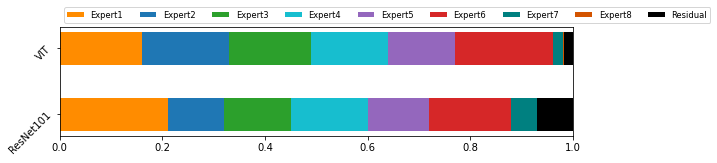

<IPython.core.display.Javascript object>

In [25]:
import numpy as np
import matplotlib.pyplot as plt


category_names = [
    "Expert1",
    "Expert2",
    "Expert3",
    "Expert4",
    "Expert5",
    "Expert6",
    "Expert7",
    "Expert8",
    "Residual",
]
results = {
    "ResNet101": [
        0.21,
        0.11,
        0.13,
        0.15,
        0.12,
        0.16,
        0.05,
        0,
        0.07,
    ],
    "VIT": [0.16, 0.17, 0.16, 0.15, 0.13, 0.19, 0.02, 0.003, 0.017],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = [
        "darkorange",
        "tab:blue",
        "tab:green",
        "tab:cyan",
        "tab:purple",
        "tab:red",
        "teal",
        "#D35400",
        "black",
    ]

    fig, ax = plt.subplots(figsize=(9.2, 2))
    #     ax.invert_yaxis()
    #     ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    #     ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

        #         r, g, b, _ = color
        text_color = "#17202A"
    #         ax.bar_label(rects, label_type="center", color=text_color)
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 1),
        loc="lower left",
        fontsize="small",
    )

    for tick in ax.get_yticklabels():
        tick.set_rotation(45)
    return fig, ax


survey(results, category_names)
plt.show()

In [26]:
preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 1183


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {1183})")
print(f"total coverage by g: {g_tot_cov}")

g_tot_acc: 86.53846153846155 (%)
bb_tot_acc: 59.61538461538461 (%)
g_tot_f1: 86.53846153846155 (%)
g_tot_precision: 86.53846153846155 (%)
g_tot_recall: 86.53846153846155 (%)
bb_tot_recall: 59.61538461538461 (%)
total samples covered by g: 1040 (out of 1183)
total coverage by g: 0.8791208791208791


<IPython.core.display.Javascript object>

In [28]:
test_tensor_preds_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_0.01_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_preds_residual.pt",
    )
)

test_tensor_preds_bb_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_0.01_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/cub/explainer/ResNet101/lr_0.01_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs",
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_residual.size())
print(test_tensor_preds_bb_residual.size())
print(test_tensor_y_residual.size())



 << Test sizes >>
torch.Size([143, 200])
torch.Size([143, 200])
torch.Size([143])


<IPython.core.display.Javascript object>

In [32]:
torch.sum(
    test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual
) / test_tensor_preds_residual.size(0)

tensor(0.8252)

<IPython.core.display.Javascript object>

In [31]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, test_tensor_preds_6, 
                     test_tensor_preds_residual,
#                    test_tensor_preds_7, test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,
                test_tensor_y_4, test_tensor_y_5, test_tensor_y_6,
                test_tensor_y_residual
#                test_tensor_y_7, test_tensor_y_8
               ), dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(),
    test_tensor_preds_bb_residual.cpu()
#     test_tensor_preds_bb_7.cpu(), test_tensor_preds_bb_8.cpu()
), 
               dim=0)

preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 1183


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {1183})")
print(f"total coverage by g: {g_tot_cov}")


g_tot_acc: 86.0524091293322 (%)
bb_tot_acc: 62.975486052409124 (%)
g_tot_f1: 86.0524091293322 (%)
g_tot_precision: 86.0524091293322 (%)
g_tot_recall: 86.0524091293322 (%)
bb_tot_recall: 62.975486052409124 (%)
total samples covered by g: 1183 (out of 1183)
total coverage by g: 1.0


<IPython.core.display.Javascript object>

In [72]:
x = [
    test_tensor_preds_1.size(0) / 1183,
    test_tensor_preds_2.size(0) / 1183,
    test_tensor_preds_3.size(0) / 1183,
    test_tensor_preds_4.size(0) / 1183,
    test_tensor_preds_5.size(0) / 1183,
    test_tensor_preds_6.size(0) / 1183,
]

print(x, sum(x), 1 - sum(x))
(
    (
        torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1)
        / test_tensor_preds_1.size(0)
    ).item()
    * (test_tensor_preds_1.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_2.argmax(dim=1) == test_tensor_y_2)
        / test_tensor_preds_2.size(0)
    ).item()
    * (test_tensor_preds_2.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_3.argmax(dim=1) == test_tensor_y_3)
        / test_tensor_preds_3.size(0)
    ).item()
    * (test_tensor_preds_3.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_4.argmax(dim=1) == test_tensor_y_4)
        / test_tensor_preds_4.size(0)
    ).item()
    * (test_tensor_preds_4.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_5.argmax(dim=1) == test_tensor_y_5)
        / test_tensor_preds_5.size(0)
    ).item()
    * (test_tensor_preds_5.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_6.argmax(dim=1) == test_tensor_y_6)
        / test_tensor_preds_6.size(0)
    ).item()
    * (test_tensor_preds_6.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual)
        / test_tensor_preds_residual.size(0)
    ).item()
    * (test_tensor_preds_residual.size(0) / 1183)
    * 100,
)

[0.20540997464074387, 0.11242603550295859, 0.1293322062552832, 0.14877430262045646, 0.12341504649196956, 0.15976331360946747] 0.8791208791208791 0.1208791208791209


(19.695689430301307,
 10.312764355416833,
 11.665257894680446,
 11.91885054161865,
 10.228233274925792,
 12.256973699705135,
 9.974640542334253)

<IPython.core.display.Javascript object>

/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/plot_cub


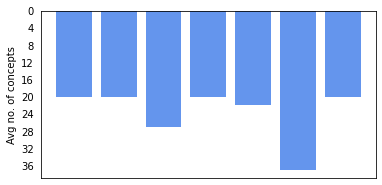

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plot_folder = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/plot_cub"
class_list = [
    "Expert1",
    "Expert2",
    "Expert3",
    "Expert4",
    "Expert5",
    "Expert6",
    "Expert7",]
accuracy = [96, 92, 90, 80, 83, 77, 82]
avg_concept_used = [20, 20, 27, 20, 22, 37, 20]
cov = [0.17, 0.17, 0.16, 0.15, 0.12, 0.19]
fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list,
   avg_concept_used,
   width=0.8,
    color="#6495ED"
   )
# invert y axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_ylim([0,  20])
ax.invert_yaxis()
ax.set_ylabel("Avg no. of concepts")
# label x axis
# ax.set_xticks(range(len(df)))
# ax.set_xticklabels(df['x_cat'],
#                fontdict={'fontsize': 14})
plt.tick_params(left = False, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

resolution_value = 300
plt.savefig(os.path.join(plot_folder, "expert_concept_top_down.png"), format="png", dpi=resolution_value)
print(plot_folder)
plt.show()


/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/plot_cub


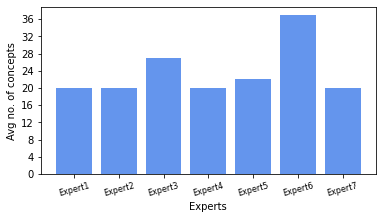

<IPython.core.display.Javascript object>

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list, avg_concept_used, width=0.8, color="#6495ED")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_yticklabels([3, 6, 9, 12, 15, 18, 21])
# ax.set_ylim([0,  20])
# ax.invert_yaxis()
ax.set_ylabel("Avg no. of concepts")
ax.set_xlabel("Experts")
ax.set_xticks(range(len(class_list)))
ax.set_xticklabels(class_list, fontdict={"fontsize": 8})
# plt.tick_params(left = False, right = False , labelleft = True ,
#                 labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

resolution_value = 300
plt.savefig(
    os.path.join(plot_folder, "expert_concept_botton_up.png"),
    format="png",
    dpi=resolution_value,
)
print(plot_folder)
plt.show()

/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/plot_cub


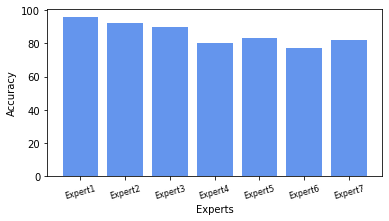

<IPython.core.display.Javascript object>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list, accuracy, width=0.8, color="#6495ED")
# invert y axis
# ax.set_yticklabels([0, 3, 6, 9, 12, 15, 18, 21])
# ax.set_ylim([0,  20])
# ax.invert_yaxis()
ax.set_ylabel("Accuracy")
ax.set_xlabel("Experts")
# label x axis
ax.set_xticks(range(len(class_list)))
ax.set_xticklabels(class_list, fontdict={"fontsize": 8})
# plt.tick_params(left = False, right = False , labelleft = True ,
#                 labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

resolution_value = 300
plt.savefig(
    os.path.join(plot_folder, "expert_acc_botton_up.png"),
    format="png",
    dpi=resolution_value,
)
print(plot_folder)
plt.show()